# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services
In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libs
import pandas as pd
import numpy as np
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from ast import literal_eval
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the general population data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias = azdias.drop('Unnamed: 0',axis=1)

### Preprocessing

In [4]:
# load in the feature value data
att_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx')

In [5]:
# load in the feature summary file
att_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

In [6]:
#check extra attributes listed in the feature summary file
att_extra = np.setdiff1d(att_info.Attribute, azdias.columns, assume_unique=True)

In [7]:
# Set attribute as index for `att_info` dataframe and drop extras
att_info.set_index('Attribute', inplace=True)
att_info.drop(att_extra, inplace=True)
att_info.shape

(264, 3)

In [8]:
# Check missing columns in the feature summary file
att_missing = np.setdiff1d(azdias.columns, att_info.index, assume_unique=True)
print('There are {} missing features.'.format(len(att_missing)))

There are 102 missing features.


In [9]:
# Create new dataframe of missing features
att_missing = pd.DataFrame(att_missing, columns=['Attribute'])
att_missing['Information level'] = np.NaN
att_missing['Description'] = np.NaN
att_missing['Additional notes'] = np.NaN
att_missing['Unnamed: 0'] = np.NaN
att_missing.set_index('Attribute', inplace=True)
print('There are {} rows and {} columns.'.format(att_missing.shape[0], att_missing.shape[1]))

There are 102 rows and 4 columns.


In [10]:
# Add dataframe of missing features to the original features information dataframe
att_info = att_info.append(att_missing)
print('There are {} rows and {} columns.'.format(att_info.shape[0], att_info.shape[1]))

There are 366 rows and 4 columns.


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [11]:
# check for any extra or missing feature
np.setdiff1d(azdias.columns, att_info.index, assume_unique=True)

array([], dtype=object)

In [12]:
# dataframe of feature wise unknown values
unknown=att_values.loc[(att_values['Meaning'].str.contains("unknown")==True)]
unknown=unknown.reset_index()

for i in range(len(unknown['Value'])):
    if type(unknown['Value'][i]) == str:
        unknown['Value'][i] = [int(s) for s in (unknown['Value'][i]).split(',')]
    else:
        unknown['Value'][i] = [unknown['Value'][i]]
        
for i in range(len(unknown['Value'])):
    if 0 not in unknown['Value'][i]:
        unknown['Value'][i].append(0)   

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
unknown_attr = pd.core.indexes.base.Index(unknown.Attribute)

In [14]:
#check for missing features in feature value file
drop_cols=[]
for item in azdias.columns:
    if item not in unknown_attr:
        drop_cols.append(item)

In [15]:
#drop features which are missing in the feature value file
azdias_un = azdias.drop(np.asarray(drop_cols), axis=1)

In [16]:
att_info = att_info.drop(np.asarray(drop_cols), axis=0)

In [17]:
#set unknown values to NaN
for i in range(len(unknown['Value'])):
        if unknown.Attribute[i] in azdias_un.columns:
            azdias_un[unknown.Attribute[i]] = azdias_un[unknown.Attribute[i]].replace(unknown.Value[i],np.NaN)   
        

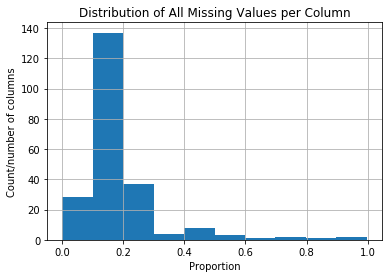

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_col = azdias_un.isnull().sum()/azdias_un.shape[0]
missing_col
missing_col.hist()
plt.xlabel('Proportion')
plt.ylabel('Count/number of columns')
plt.title('Distribution of All Missing Values per Column');

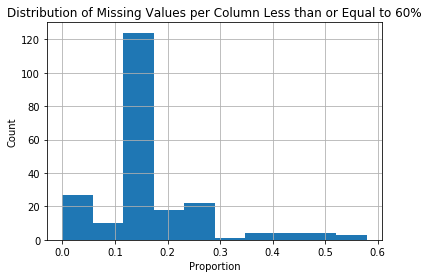

In [19]:
# Investigate patterns in the amount of missing data in each column.
missing_col_sub = missing_col[missing_col<=0.6]

missing_col_sub.hist()
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of Missing Values per Column Less than or Equal to 60%');

In [20]:
# Remove the outlier columns from the dataset
col_outlier = missing_col[missing_col > 0.6].index
azdias_sub = azdias_un.drop(col_outlier, axis=1)

In [21]:
col_outlier

Index(['AGER_TYP', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_SEG6', 'KBA05_SEG8',
       'TITEL_KZ'],
      dtype='object')

In [22]:
# Remove the outlier attributes from the feature info dataframe
att_info_new = att_info[att_info.index.isin(col_outlier) == False]
att_info_new.shape

(217, 4)

In [23]:
# find numerical columns
num_cols = azdias_sub._get_numeric_data().columns
num_cols

Index(['ALTER_HH', 'BALLRAUM', 'CJT_GESAMTTYP', 'EWDICHTE', 'FINANZ_ANLEGER',
       'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER',
       ...
       'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_TYP',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=215)

In [24]:
#find categorical columns
list(set(azdias_sub.columns) - set(num_cols))

['OST_WEST_KZ', 'CAMEO_DEUG_2015']

In [25]:
att_categorical =['OST_WEST_KZ', 'CAMEO_DEUG_2015']

In [26]:
# Check categorical variable whether it is binary or multi-level
cat_binary = []
cat_multi_level = []
for att in att_categorical:
    if len(azdias_sub[att].value_counts()) == 2:
        cat_binary.append(att)
    else:
        cat_multi_level.append(att)

In [27]:
#categorical binary variables
cat_binary

['OST_WEST_KZ']

In [28]:
# Re-encode the values as numbers for `OST_WEST_KZ`
azdias_sub['OST_WEST_KZ'] = azdias_sub['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
azdias_sub['OST_WEST_KZ'].value_counts()

2.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64

In [29]:
#categorical multilevel variables
cat_multi_level

['CAMEO_DEUG_2015']

In [30]:
# Check numerical variable whether it is binary or multi-level
num_binary = []
num_multi_level = []
for att in num_cols:
    if len(azdias_sub[att].value_counts()) == 2:
        num_binary.append(att)
    else:
        num_multi_level.append(att)

In [31]:
#numerical binary variables
num_binary

['PLZ8_ANTG4', 'VERS_TYP', 'ANREDE_KZ']

In [32]:
#numerical multilevel variables
num_multi_level

['ALTER_HH',
 'BALLRAUM',
 'CJT_GESAMTTYP',
 'EWDICHTE',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'FINANZTYP',
 'GEBAEUDETYP',
 'HEALTH_TYP',
 'HH_EINKOMMEN_SCORE',
 'INNENSTADT',
 'KBA05_ALTER1',
 'KBA05_ALTER2',
 'KBA05_ALTER3',
 'KBA05_ALTER4',
 'KBA05_ANHANG',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_BAUMAX',
 'KBA05_CCM1',
 'KBA05_CCM2',
 'KBA05_CCM3',
 'KBA05_CCM4',
 'KBA05_DIESEL',
 'KBA05_FRAU',
 'KBA05_GBZ',
 'KBA05_HERST1',
 'KBA05_HERST2',
 'KBA05_HERST3',
 'KBA05_HERST4',
 'KBA05_HERST5',
 'KBA05_HERSTTEMP',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_KRSKLEIN',
 'KBA05_KRSOBER',
 'KBA05_KRSVAN',
 'KBA05_KRSZUL',
 'KBA05_KW1',
 'KBA05_KW2',
 'KBA05_KW3',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA05_MOD1',
 'KBA05_MOD2',
 'KBA05_MOD3',
 'KBA05_MOD4',
 'KBA05_MOD8',
 'KBA05_MODTEMP',
 'KBA05_MOTOR',
 

In [33]:
num_multi_level.remove('PRAEGENDE_JUGENDJAHRE')

In [34]:
multi_level = cat_multi_level + num_multi_level


In [35]:
# Re-encode categorical variables
azdias_enc = pd.get_dummies(azdias_sub, columns=multi_level)

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and add two new variables.
# Add new column `DECADE`
azdias_enc['DECADE'] = azdias_enc['PRAEGENDE_JUGENDJAHRE']

# Add new column `MOVEMENT`
mainstream = [1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
avantgarde = [2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]

main = azdias_enc['PRAEGENDE_JUGENDJAHRE'].isin(mainstream)
azdias_enc.loc[main, 'MOVEMENT'] = 1.0
avant = azdias_enc['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde)
azdias_enc.loc[avant, 'MOVEMENT'] = 2.0

In [37]:
azdias_clean = azdias_enc.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

### Preprocessing Function

In [38]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
  
    #drop columns which are missing in feature value file
    df_un = df.drop(np.asarray(drop_cols), axis=1)
    
    # convert missing value codes into NaNs
    for i in range(len(unknown['Value'])):
        if unknown.Attribute[i] in df_un.columns:
            df_un[unknown.Attribute[i]] = df_un[unknown.Attribute[i]].replace(unknown.Value[i],np.NaN)      
   
    # remove columns having more than 60% unknown values
    col_outlier = ['AGER_TYP', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_SEG6', 'KBA05_SEG8',
       'TITEL_KZ']
   
    df_sub = df_un.drop(col_outlier, axis=1)
    
    # select, re-encode, and engineer column values.
    df_sub['OST_WEST_KZ'] = df_sub['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
    
    categorical = [  'CAMEO_DEUG_2015',
                     'ALTER_HH',
                     'BALLRAUM',
                     'CJT_GESAMTTYP',
                     'EWDICHTE',
                     'FINANZ_ANLEGER',
                     'FINANZ_HAUSBAUER',
                     'FINANZ_MINIMALIST',
                     'FINANZ_SPARER',
                     'FINANZ_UNAUFFAELLIGER',
                     'FINANZ_VORSORGER',
                     'FINANZTYP',
                     'GEBAEUDETYP',
                     'HEALTH_TYP',
                     'HH_EINKOMMEN_SCORE',
                     'INNENSTADT',
                     'KBA05_ALTER1',
                     'KBA05_ALTER2',
                     'KBA05_ALTER3',
                     'KBA05_ALTER4',
                     'KBA05_ANHANG',
                     'KBA05_ANTG1',
                     'KBA05_ANTG2',
                     'KBA05_BAUMAX',
                     'KBA05_CCM1',
                     'KBA05_CCM2',
                     'KBA05_CCM3',
                     'KBA05_CCM4',
                     'KBA05_DIESEL',
                     'KBA05_FRAU',
                     'KBA05_GBZ',
                     'KBA05_HERST1',
                     'KBA05_HERST2',
                     'KBA05_HERST3',
                     'KBA05_HERST4',
                     'KBA05_HERST5',
                     'KBA05_HERSTTEMP',
                     'KBA05_KRSAQUOT',
                     'KBA05_KRSHERST1',
                     'KBA05_KRSHERST2',
                     'KBA05_KRSHERST3',
                     'KBA05_KRSKLEIN',
                     'KBA05_KRSOBER',
                     'KBA05_KRSVAN',
                     'KBA05_KRSZUL',
                     'KBA05_KW1',
                     'KBA05_KW2',
                     'KBA05_KW3',
                     'KBA05_MAXAH',
                     'KBA05_MAXBJ',
                     'KBA05_MAXHERST',
                     'KBA05_MAXSEG',
                     'KBA05_MAXVORB',
                     'KBA05_MOD1',
                     'KBA05_MOD2',
                     'KBA05_MOD3',
                     'KBA05_MOD4',
                     'KBA05_MOD8',
                     'KBA05_MODTEMP',
                     'KBA05_MOTOR',
                     'KBA05_MOTRAD',
                     'KBA05_SEG1',
                     'KBA05_SEG10',
                     'KBA05_SEG2',
                     'KBA05_SEG3',
                     'KBA05_SEG4',
                     'KBA05_SEG5',
                     'KBA05_SEG7',
                     'KBA05_SEG9',
                     'KBA05_VORB0',
                     'KBA05_VORB1',
                     'KBA05_VORB2',
                     'KBA05_ZUL1',
                     'KBA05_ZUL2',
                     'KBA05_ZUL3',
                     'KBA05_ZUL4',
                     'KBA13_ALTERHALTER_30',
                     'KBA13_ALTERHALTER_45',
                     'KBA13_ALTERHALTER_60',
                     'KBA13_ALTERHALTER_61',
                     'KBA13_AUDI',
                     'KBA13_AUTOQUOTE',
                     'KBA13_BJ_1999',
                     'KBA13_BJ_2000',
                     'KBA13_BJ_2004',
                     'KBA13_BJ_2006',
                     'KBA13_BJ_2008',
                     'KBA13_BJ_2009',
                     'KBA13_BMW',
                     'KBA13_CCM_0_1400',
                     'KBA13_CCM_1000',
                     'KBA13_CCM_1200',
                     'KBA13_CCM_1400',
                     'KBA13_CCM_1500',
                     'KBA13_CCM_1600',
                     'KBA13_CCM_1800',
                     'KBA13_CCM_2000',
                     'KBA13_CCM_2500',
                     'KBA13_CCM_2501',
                     'KBA13_CCM_3000',
                     'KBA13_CCM_3001',
                     'KBA13_FAB_ASIEN',
                     'KBA13_FAB_SONSTIGE',
                     'KBA13_FIAT',
                     'KBA13_FORD',
                     'KBA13_HALTER_20',
                     'KBA13_HALTER_25',
                     'KBA13_HALTER_30',
                     'KBA13_HALTER_35',
                     'KBA13_HALTER_40',
                     'KBA13_HALTER_45',
                     'KBA13_HALTER_50',
                     'KBA13_HALTER_55',
                     'KBA13_HALTER_60',
                     'KBA13_HALTER_65',
                     'KBA13_HALTER_66',
                     'KBA13_HERST_ASIEN',
                     'KBA13_HERST_AUDI_VW',
                     'KBA13_HERST_BMW_BENZ',
                     'KBA13_HERST_EUROPA',
                     'KBA13_HERST_FORD_OPEL',
                     'KBA13_HERST_SONST',
                     'KBA13_KMH_0_140',
                     'KBA13_KMH_110',
                     'KBA13_KMH_140',
                     'KBA13_KMH_140_210',
                     'KBA13_KMH_180',
                     'KBA13_KMH_211',
                     'KBA13_KMH_250',
                     'KBA13_KMH_251',
                     'KBA13_KRSAQUOT',
                     'KBA13_KRSHERST_AUDI_VW',
                     'KBA13_KRSHERST_BMW_BENZ',
                     'KBA13_KRSHERST_FORD_OPEL',
                     'KBA13_KRSSEG_KLEIN',
                     'KBA13_KRSSEG_OBER',
                     'KBA13_KRSSEG_VAN',
                     'KBA13_KRSZUL_NEU',
                     'KBA13_KW_0_60',
                     'KBA13_KW_110',
                     'KBA13_KW_120',
                     'KBA13_KW_121',
                     'KBA13_KW_30',
                     'KBA13_KW_40',
                     'KBA13_KW_50',
                     'KBA13_KW_60',
                     'KBA13_KW_61_120',
                     'KBA13_KW_70',
                     'KBA13_KW_80',
                     'KBA13_KW_90',
                     'KBA13_MAZDA',
                     'KBA13_MERCEDES',
                     'KBA13_MOTOR',
                     'KBA13_NISSAN',
                     'KBA13_OPEL',
                     'KBA13_PEUGEOT',
                     'KBA13_RENAULT',
                     'KBA13_SEG_GELAENDEWAGEN',
                     'KBA13_SEG_GROSSRAUMVANS',
                     'KBA13_SEG_KLEINST',
                     'KBA13_SEG_KLEINWAGEN',
                     'KBA13_SEG_KOMPAKTKLASSE',
                     'KBA13_SEG_MINIVANS',
                     'KBA13_SEG_MINIWAGEN',
                     'KBA13_SEG_MITTELKLASSE',
                     'KBA13_SEG_OBEREMITTELKLASSE',
                     'KBA13_SEG_OBERKLASSE',
                     'KBA13_SEG_SONSTIGE',
                     'KBA13_SEG_SPORTWAGEN',
                     'KBA13_SEG_UTILITIES',
                     'KBA13_SEG_VAN',
                     'KBA13_SEG_WOHNMOBILE',
                     'KBA13_SITZE_4',
                     'KBA13_SITZE_5',
                     'KBA13_SITZE_6',
                     'KBA13_TOYOTA',
                     'KBA13_VORB_0',
                     'KBA13_VORB_1',
                     'KBA13_VORB_1_2',
                     'KBA13_VORB_2',
                     'KBA13_VORB_3',
                     'KBA13_VW',
                     'KKK',
                     'NATIONALITAET_KZ',
                     'ORTSGR_KLS9',
                     'PLZ8_ANTG1',
                     'PLZ8_ANTG2',
                     'PLZ8_ANTG3',
                     'PLZ8_GBZ',
                     'PLZ8_HHZ',
                     'REGIOTYP',
                     'RETOURTYP_BK_S',
                     'SEMIO_DOM',
                     'SEMIO_ERL',
                     'SEMIO_FAM',
                     'SEMIO_KAEM',
                     'SEMIO_KRIT',
                     'SEMIO_KULT',
                     'SEMIO_LUST',
                     'SEMIO_MAT',
                     'SEMIO_PFLICHT',
                     'SEMIO_RAT',
                     'SEMIO_REL',
                     'SEMIO_SOZ',
                     'SEMIO_TRADV',
                     'SEMIO_VERT',
                     'SHOPPER_TYP',
                     'W_KEIT_KIND_HH',
                     'WOHNDAUER_2008',
                     'WOHNLAGE',
                     'ZABEOTYP',
                     'ALTERSKATEGORIE_GROB']
    
    df_enc = pd.get_dummies(df_sub, columns=categorical)
    
    # Engineer mixed-type features
    df_enc['DECADE'] = df_enc['PRAEGENDE_JUGENDJAHRE']
    main = df_enc['PRAEGENDE_JUGENDJAHRE'].isin([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
    df_enc.loc[main, 'MOVEMENT'] = 1.0
    avant = df_enc['PRAEGENDE_JUGENDJAHRE'].isin([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])
    df_enc.loc[avant, 'MOVEMENT'] = 2.0
    
   
    df_clean = df_enc.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

    # Return the cleaned dataframe.

    return df_clean

In [39]:
#use cleaning function
azdias_clone = clean_data(azdias)

In [40]:
#Test cleaning function
# Should be True
azdias_clone.shape == azdias_clean.shape

True

In [41]:
# Apply `Imputer` to replace all missing values with the mean
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
azdias_impute = imputer.fit_transform(azdias_clean.sample(frac=0.6))

In [42]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_impute)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal Component Analysis

In [43]:
# Apply PCA to the data
n_components = int(azdias_impute.shape[1] / 2) # Half the number of features

pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_scaled)

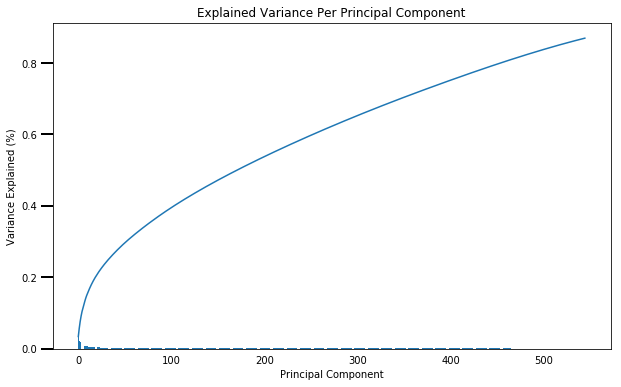

In [44]:
# Investigate the variance accounted for by each principal component
ind = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot()
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(n_components):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain
sum(pca.explained_variance_ratio_)

0.8694544182754353

In [46]:
# Map weights for the first principal components to corresponding feature names
# and then print the linked values, sorted by weight

# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_clean.keys())
components.index = dimensions

In [47]:
components.iloc[0].sort_values(ascending=False)

SEMIO_VERT_1                       0.1133
FINANZTYP_4                        0.1036
SEMIO_DOM_6                        0.1013
HH_EINKOMMEN_SCORE_2.0             0.0972
FINANZ_UNAUFFAELLIGER_5            0.0934
SEMIO_KRIT_7                       0.0920
SEMIO_LUST_5                       0.0913
SEMIO_MAT_5                        0.0906
FINANZ_SPARER_4                    0.0885
SEMIO_FAM_6                        0.0884
SEMIO_PFLICHT_5                    0.0867
SEMIO_KAEM_6                       0.0844
SEMIO_ERL_3                        0.0830
SEMIO_REL_7                        0.0813
FINANZ_ANLEGER_5                   0.0805
SEMIO_KULT_3                       0.0803
FINANZ_VORSORGER_3                 0.0774
SEMIO_SOZ_2                        0.0768
SEMIO_TRADV_3                      0.0745
FINANZ_HAUSBAUER_3                 0.0691
FINANZ_MINIMALIST_3                0.0667
SEMIO_RAT_4                        0.0657
CJT_GESAMTTYP_6.0                  0.0599
ZABEOTYP_3                        

In [48]:
components.iloc[1].sort_values(ascending=False)

PLZ8_ANTG1_1.0                 0.1310
PLZ8_ANTG3_3.0                 0.1277
HH_EINKOMMEN_SCORE_6.0         0.1087
KBA13_CCM_3000_1.0             0.0978
KBA13_AUTOQUOTE_1.0            0.0971
EWDICHTE_6.0                   0.0966
KBA13_HALTER_30_5.0            0.0941
KBA13_CCM_2501_1.0             0.0927
KBA13_CCM_3001_1.0             0.0927
KBA13_SEG_SPORTWAGEN_1.0       0.0921
PLZ8_GBZ_2.0                   0.0909
PLZ8_ANTG2_4.0                 0.0869
KBA13_KW_120_1.0               0.0863
KBA13_ALTERHALTER_30_5.0       0.0863
KBA13_HALTER_35_5.0            0.0858
KBA13_KRSSEG_OBER_1.0          0.0850
KBA13_SEG_KOMPAKTKLASSE_5.0    0.0837
KBA13_SEG_GELAENDEWAGEN_1.0    0.0827
PLZ8_ANTG4                     0.0798
KBA13_ALTERHALTER_60_1.0       0.0781
KBA13_SEG_OBERKLASSE_1.0       0.0774
KBA13_HALTER_55_1.0            0.0772
KBA13_SITZE_5_5.0              0.0771
KBA13_SITZE_6_1.0              0.0749
KBA13_MERCEDES_1.0             0.0730
KBA13_HALTER_25_5.0            0.0726
KBA13_KRSAQU

In [49]:
components.iloc[2].sort_values(ascending=False)

EWDICHTE_6.0                       0.1080
KBA13_HERST_BMW_BENZ_5.0           0.1075
KBA13_SEG_SPORTWAGEN_5.0           0.1056
BALLRAUM_1.0                       0.1009
KBA13_SEG_OBERKLASSE_5.0           0.0968
KBA13_SITZE_4_5.0                  0.0955
KBA13_ALTERHALTER_60_1.0           0.0932
KBA13_KW_121_5.0                   0.0928
KBA13_HALTER_35_5.0                0.0926
KBA13_KMH_211_5.0                  0.0893
KBA13_CCM_2501_5.0                 0.0890
KBA13_BMW_5.0                      0.0882
KBA13_SEG_OBEREMITTELKLASSE_5.0    0.0875
KBA13_HERST_FORD_OPEL_1.0          0.0873
KBA13_KMH_250_5.0                  0.0865
KBA13_HALTER_55_1.0                0.0865
KBA13_SITZE_5_1.0                  0.0864
KBA13_KMH_140_210_1.0              0.0862
ORTSGR_KLS9_9.0                    0.0856
KBA13_ALTERHALTER_45_5.0           0.0844
KBA13_AUTOQUOTE_1.0                0.0840
KBA05_KW3_4.0                      0.0823
KBA13_CCM_3001_5.0                 0.0816
KBA13_HALTER_40_5.0               

### General Population Clustering

In [50]:
# Over a number of different cluster counts
scores = []
centers = list(range(1,31))
for center in centers:
    
    # run k-means clustering on the data
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=28)
    model = kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances
    score = np.abs(model.score(azdias_pca))
    scores.append(score)

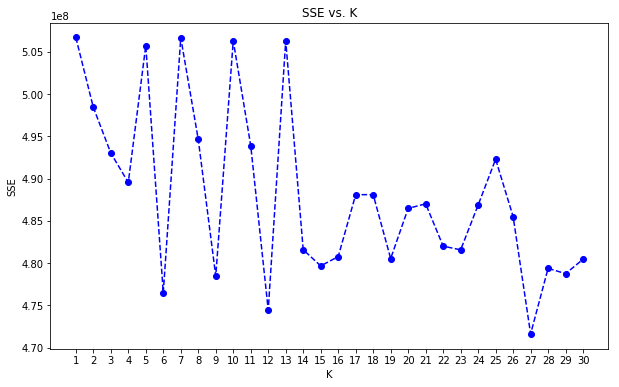

In [51]:
# Investigate the change in within-cluster distance across number of clusters

plt.figure(figsize=(10, 6))
ax = plt.subplot()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(np.arange(1, 31, step=1))
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data

kmeans = KMeans(n_clusters=30, random_state=42, n_jobs=-1)
azdias_preds = kmeans.fit_predict(azdias_pca)

In [53]:
azdias_cluster = pd.DataFrame(np.round(azdias_pca, 4), columns = dimensions)
azdias_cluster.insert(loc=0, column='Cluster', value=azdias_preds)

In [54]:
azdias_cluster.head()

,Cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 536,Dimension 537,Dimension 538,Dimension 539,Dimension 540,Dimension 541,Dimension 542,Dimension 543,Dimension 544,Dimension 545
0,1,-4.2600,-3.6336,1.8730,0.7765,-6.2979,2.2957,1.0281,-2.5737,3.4261,...,0.4179,0.7044,-1.0483,-0.6048,0.3414,-0.2166,-0.8349,0.6079,0.6547,-0.0684
1,1,-2.8996,3.9783,1.8537,1.5351,-4.6961,-0.2748,3.2390,2.6283,4.0686,...,-2.0832,0.8259,-0.0660,1.4110,1.0839,0.2288,0.9203,0.7990,1.9117,0.7065
2,12,17.2328,-2.1789,-0.8456,0.1156,-0.8711,-0.5612,0.3561,-0.4919,0.2620,...,-0.2784,0.0984,0.1305,-0.6771,0.0364,0.3766,-0.0400,-0.2929,0.2222,0.3916
3,29,-2.0628,2.8638,-6.7567,2.8891,-2.7747,5.4072,-7.0247,-1.8014,-0.2509,...,0.2023,-2.0590,-0.0132,-1.3673,-0.4882,-0.8929,-1.4882,1.0432,-0.5902,-1.1361
4,7,-1.1387,-7.1566,11.9248,5.8937,10.7731,-2.4895,-3.0699,0.7094,-1.1185,...,-0.4372,-0.3659,0.2567,-0.3980,-1.4989,1.0691,1.2150,1.4410,0.9551,1.0527


### Customer Data Clustering

In [55]:
#load in the customer data
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
customers = customers.drop('Unnamed: 0',axis=1)

In [57]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [58]:
#Drop extra features
customers_sub = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
print(customers_sub.shape)
customers_sub.head()

(191652, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [59]:
# Apply preprocessing onto the customer data using cleaning function
customers_clean = clean_data(customers_sub)

In [60]:
# Check for missing column in `customers_clean`
missing = list(np.setdiff1d(azdias_clean.columns, customers_clean.columns))
missing

['ALTER_HH_1.0', 'GEBAEUDETYP_5.0']

In [61]:
# Add the missing column with default value of 0
for m in missing:
    customers_clean[m] = 0
    customers_clean[m] = customers_clean[m].astype('uint8')
    
print(customers_clean.shape)
customers_clean.head()

(191652, 1090)


,OST_WEST_KZ,PLZ8_ANTG4,VERS_TYP,ANREDE_KZ,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,...,ZABEOTYP_6,ALTERSKATEGORIE_GROB_1,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,DECADE,MOVEMENT,ALTER_HH_1.0,GEBAEUDETYP_5.0
0,2.0,NaN,1.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,4.0,2.0,0,0
1,NaN,NaN,1.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,NaN,NaN,0,0
2,2.0,1.0,2.0,2,0,0,0,0,1,0,...,0,0,0,0,1,0,4.0,2.0,0,0
3,2.0,NaN,1.0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,1.0,1.0,0,0
4,2.0,1.0,2.0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,8.0,1.0,0,0


In [62]:
# Apply feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data

customers_impute = imputer.transform(customers_clean)
customers_scaled = scaler.transform(customers_impute)
customers_pca = pca.transform(customers_scaled)
customers_preds = kmeans.predict(customers_pca)

In [63]:
customers_cluster = pd.DataFrame(np.round(customers_pca, 4), columns = dimensions)
customers_cluster.insert(loc=0, column='Cluster', value=customers_preds)
customers_cluster.head()

,Cluster,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,...,Dimension 536,Dimension 537,Dimension 538,Dimension 539,Dimension 540,Dimension 541,Dimension 542,Dimension 543,Dimension 544,Dimension 545
0,18,0.8082,8.5003,1.7538,6.9675,5.4986,-0.9485,3.3201,3.0168,6.5386,...,-0.0097,1.9187,0.9943,1.2399,-1.5429,-0.8209,1.7745,2.1066,-0.7387,-1.0349
1,12,11.1449,-0.9917,-0.7038,0.0597,0.2905,1.7924,2.4406,-1.7392,1.4742,...,-0.3407,0.2763,-0.2301,0.0488,0.0354,-0.3292,0.4643,-0.2294,0.5121,0.6143
2,18,0.4682,6.4982,1.0559,7.8088,5.4708,1.6432,-0.3439,3.2055,7.3803,...,-1.9401,1.0211,-0.1199,2.3771,1.5604,-0.7672,-1.0746,-2.9877,-0.5582,1.1932
3,18,1.0388,7.2238,1.5771,7.0329,4.8094,-1.8382,4.2681,2.4722,6.5234,...,-2.4978,-1.1312,1.8410,-0.8447,-0.4981,0.1499,-0.6824,-0.3072,-0.8880,-1.2404
4,3,1.4145,6.9590,1.2907,11.0434,6.9890,1.5858,-0.0876,0.7220,7.0712,...,-1.0258,0.3250,0.4785,-0.0077,-0.4473,-1.7441,-0.5787,3.3843,-0.1940,-1.3509


### Comparison of General Population and Customer Clusters

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population

def show_proportion(df_cluster, title='Default Title'):    
    #get order of bars by frequency
    cluster_counts = df_cluster['Cluster'].value_counts()
    cluster_order = cluster_counts.index

    #compute largest proportion
    n_model = df_cluster.shape[0]
    max_cluster_count = cluster_counts.iloc[0]
    max_prop = max_cluster_count / n_model

    #establish tick locations and create plot
    base_color = sns.color_palette()[0]
    tick_props = np.arange(0, max_prop, 0.02)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    base_color = sns.color_palette()[0]
    sns.countplot(data=df_cluster, y='Cluster', color=base_color, order=cluster_order)
    plt.xticks(tick_props * n_model, tick_names)
    plt.xlabel('proportion')
    plt.title(title);

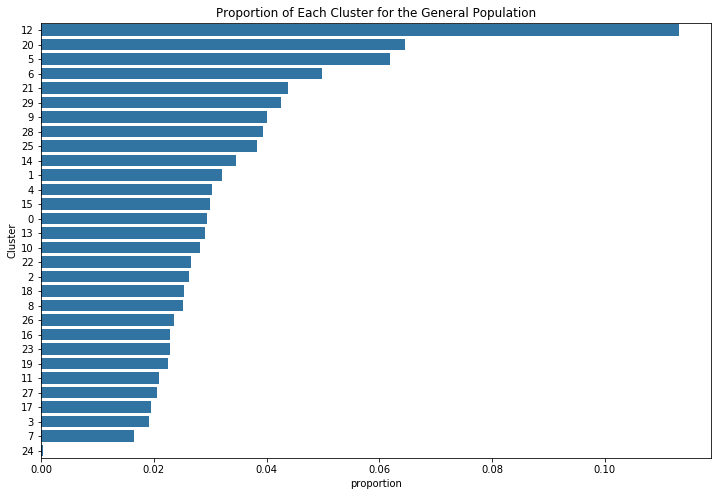

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
show_proportion(azdias_cluster, title='Proportion of Each Cluster for the General Population')

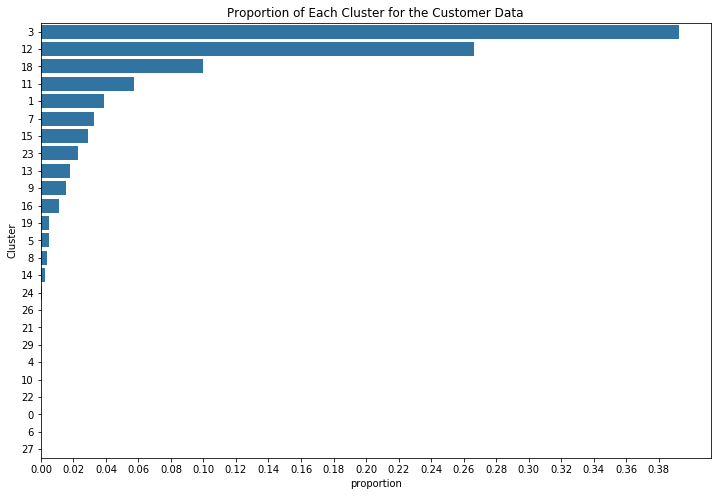

In [66]:
fig, ax = plt.subplots(figsize=(12,8))
show_proportion(customers_cluster, title='Proportion of Each Cluster for the Customer Data')

In [67]:
# Check for overrepresentation and underrepresentation of clusters between the two datasets
azdias_prop = azdias_cluster['Cluster'].value_counts() / azdias_cluster.shape[0]
customers_prop = customers_cluster['Cluster'].value_counts() / customers_cluster.shape[0]
diff_prop = customers_prop - azdias_prop

max_index = diff_prop.sort_values(ascending=False).index[0]
max_diff = diff_prop.sort_values(ascending=False).iloc[0]
min_index = diff_prop.sort_values(ascending=False).index[-6]
min_diff = diff_prop.sort_values(ascending=False).iloc[-6]

In [68]:
diff_prop.sort_values(ascending=False)

3     0.373209
12    0.153494
18    0.074190
11    0.036058
7     0.016025
1     0.006610
23    0.000260
24    0.000212
15   -0.001164
13   -0.011457
16   -0.011875
19   -0.017640
27   -0.020591
8    -0.021678
26   -0.023322
9    -0.024573
22   -0.026550
10   -0.028225
0    -0.029433
4    -0.030301
14   -0.031844
29   -0.042502
21   -0.043672
6    -0.049880
5    -0.057153
2          NaN
17         NaN
20         NaN
25         NaN
28         NaN
Name: Cluster, dtype: float64

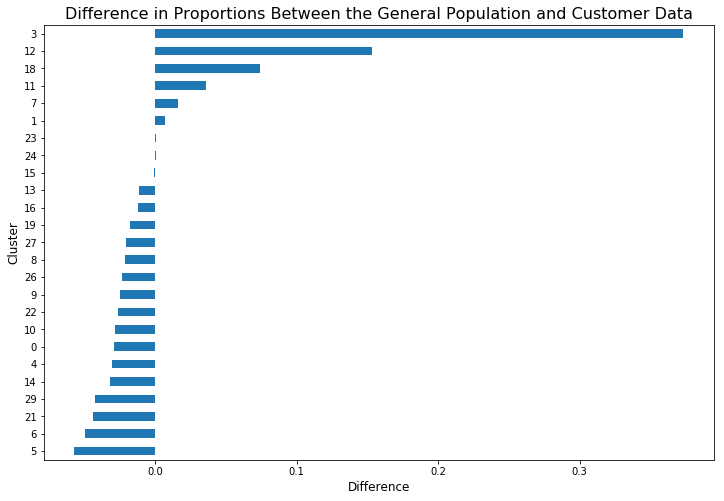

In [69]:
fig, ax = plt.subplots(figsize=(12,8))
diff_prop.sort_values()[:25].plot.barh(color=sns.color_palette()[0])
plt.title("Difference in Proportions Between the General Population and Customer Data", fontsize=16)
plt.xlabel("Difference", fontsize=12)
plt.ylabel("Cluster", fontsize=12);

In [70]:
# Function to transform centroids back to the original data space based on cluster number
def infer_cluster(index):
    
    # Subset the customers_cluster dataframe by the selected index
    cluster = customers_cluster[customers_cluster['Cluster'] == index]
    cluster_drop = cluster.drop('Cluster', axis=1)
    
    # Perform inverse PCA and inverse scaling to return to the original values
    cluster_pca = pca.inverse_transform(cluster_drop)
    cluster_scaler = scaler.inverse_transform(cluster_pca)
    
    # Create a new dataframe of the cluster and reuse the feature columns
    cluster_final = pd.DataFrame(cluster_scaler, columns=customers_clean.columns)
    return cluster_final


In [71]:
#infer features from Principal Component Analysis.
infer_columns = ['SEMIO_VERT_1',
                 'FINANZTYP_4',
                 'SEMIO_DOM_6',              
                 'PLZ8_ANTG1_1.0',                       
                 'PLZ8_ANTG3_3.0',   
                 'HH_EINKOMMEN_SCORE_6.0',
                 'EWDICHTE_6.0',
                 'KBA13_HERST_BMW_BENZ_5.0',
                 'KBA13_SEG_SPORTWAGEN_5.0']

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print('The cluster which is the most overrepresented is cluster {} with a difference of {}.'
         .format(max_index, np.round(max_diff, 4)))

The cluster which is the most overrepresented is cluster 3 with a difference of 0.3732.


In [73]:
over_cluster = infer_cluster(max_index)
print(over_cluster.shape)
over_cluster.head()

(75196, 1090)


,OST_WEST_KZ,PLZ8_ANTG4,VERS_TYP,ANREDE_KZ,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,...,ZABEOTYP_6,ALTERSKATEGORIE_GROB_1,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,DECADE,MOVEMENT,ALTER_HH_1.0,GEBAEUDETYP_5.0
0,1.227573,1.398437,1.926986,1.343381,0.066139,-0.037299,-0.012540,-0.051645,0.102124,0.021029,...,0.107250,-0.066030,-0.148785,-0.003842,-0.441391,-0.495560,1.121512,0.819282,8.838216,0.931909
1,1.456836,1.187924,1.247200,1.117304,-0.020801,0.323629,-0.047051,0.205199,1.069276,0.064302,...,-0.076939,-0.172944,0.260139,-0.234723,-0.517874,-0.296933,0.523147,1.526383,7.573597,0.693662
2,1.643674,1.501978,0.379206,1.502970,-0.103922,0.251010,0.986357,0.172074,0.212532,0.024543,...,0.012041,-0.489586,0.363444,-0.770515,0.231591,-0.211218,0.166378,1.583764,6.365726,0.694270
3,1.991342,1.201582,1.539469,1.572538,0.087307,-0.004631,0.087468,0.103089,0.087902,0.052799,...,0.397885,-0.216720,0.083065,-0.278642,0.493699,-0.115268,0.006468,0.893743,3.113857,0.737223
4,1.640105,1.229165,1.244327,1.226635,0.196168,0.915278,-0.130518,-0.172933,0.010534,-0.007053,...,-0.528856,-0.141171,0.170745,-0.431064,-0.309372,-0.403687,0.482067,1.662056,4.324365,0.688900


In [74]:
over_cluster[infer_columns].describe()

,SEMIO_VERT_1,FINANZTYP_4,SEMIO_DOM_6,PLZ8_ANTG1_1.0,PLZ8_ANTG3_3.0,HH_EINKOMMEN_SCORE_6.0,EWDICHTE_6.0,KBA13_HERST_BMW_BENZ_5.0,KBA13_SEG_SPORTWAGEN_5.0
count,75196.000000,75196.000000,75196.000000,75196.000000,75196.000000,75196.000000,75196.000000,75196.000000,75196.000000
mean,-0.225099,-0.019629,0.666060,0.037460,0.024534,0.254107,-0.203478,0.101387,-0.097669
std,0.208230,0.161682,0.296717,0.252934,0.287525,0.318564,0.392328,0.379219,0.413929
min,-0.778857,-0.588499,-0.436426,-0.705594,-7.493264,-0.712818,-1.550091,-1.209281,-1.689933
25%,-0.383763,-0.136212,0.433651,-0.127449,-0.169332,0.045406,-0.477093,-0.164921,-0.408193
50%,-0.239149,-0.026710,0.679495,0.015325,0.020955,0.200246,-0.194291,0.070652,-0.039454
75%,-0.072941,0.095522,0.894755,0.162240,0.214966,0.413145,0.068551,0.353521,0.189917
max,0.492799,1.978784,2.056302,1.268493,1.218978,2.486622,1.939506,4.199998,2.065056


In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print('The cluster which is the most underrepresented is cluster {} with a difference of {}.'
         .format(min_index, np.round(min_diff, 4)))

The cluster which is the most underrepresented is cluster 5 with a difference of -0.0572.


In [76]:
under_cluster = infer_cluster(min_index)
print(under_cluster.shape)
under_cluster.head()

(918, 1090)


,OST_WEST_KZ,PLZ8_ANTG4,VERS_TYP,ANREDE_KZ,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,...,ZABEOTYP_6,ALTERSKATEGORIE_GROB_1,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ALTERSKATEGORIE_GROB_9,DECADE,MOVEMENT,ALTER_HH_1.0,GEBAEUDETYP_5.0
0,1.663456,1.597169,1.795874,1.571830,0.059593,0.024693,-0.074475,0.896460,0.112953,-0.016784,...,-0.334351,0.024965,-0.122227,-0.027458,-0.274429,-0.954730,1.470449,0.786168,6.818574,1.133212
1,1.838632,1.226837,2.187609,1.643882,0.061820,-0.014660,0.043418,0.078728,0.002633,-0.043963,...,0.543164,-0.236839,0.083447,-0.284420,-0.154330,-1.065189,1.695075,0.808864,7.261413,1.102517
2,1.670609,1.653252,1.966745,1.788104,0.076731,0.151332,0.861835,-0.120077,-0.057933,-0.046757,...,-0.317000,-0.006523,0.060625,-0.616204,-0.577785,-1.213427,1.804484,1.602931,7.726699,0.576743
3,1.736405,1.411488,1.796851,1.765174,0.190582,0.084058,-0.186322,-0.062861,0.094084,0.975752,...,-0.318097,-0.025703,0.480564,-0.583405,-0.639415,-1.100082,1.659013,1.663889,8.535202,1.333004
4,1.716532,1.404862,2.158212,1.522925,0.037063,0.933456,-0.129167,-0.188371,0.043521,-0.033750,...,-0.234755,-0.185768,0.338217,-0.735875,-0.360749,-1.330562,1.792940,1.634247,6.513949,0.655983


In [77]:
under_cluster[infer_columns].describe()

,SEMIO_VERT_1,FINANZTYP_4,SEMIO_DOM_6,PLZ8_ANTG1_1.0,PLZ8_ANTG3_3.0,HH_EINKOMMEN_SCORE_6.0,EWDICHTE_6.0,KBA13_HERST_BMW_BENZ_5.0,KBA13_SEG_SPORTWAGEN_5.0
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,-0.169760,-0.042240,0.566487,0.174680,0.224206,0.161202,0.134068,0.272156,0.266207
std,0.137974,0.191863,0.295121,0.343851,0.290309,0.404987,0.385938,0.417115,0.414706
min,-0.585008,-0.560598,-0.344838,-0.623885,-0.672457,-0.710327,-1.184409,-0.692973,-1.175477
25%,-0.255850,-0.165706,0.337953,-0.080737,0.024159,-0.113500,-0.107710,-0.034640,0.006770
50%,-0.170486,-0.070100,0.569748,0.094610,0.229160,0.056971,0.171746,0.218369,0.255059
75%,-0.079203,0.065455,0.783791,0.491429,0.440621,0.338404,0.431733,0.553122,0.499922
max,0.242500,0.827793,1.741137,0.924350,1.097280,1.453876,0.940717,1.554631,1.395927


In [78]:
# Compare the differences between the target and non-target groups
over_mean = over_cluster[infer_columns].describe().loc['mean']
under_mean = under_cluster[infer_columns].describe().loc['mean']
mean_df = pd.concat([over_mean, under_mean], axis=1)
mean_df.columns = ['Target', 'Non-Target']

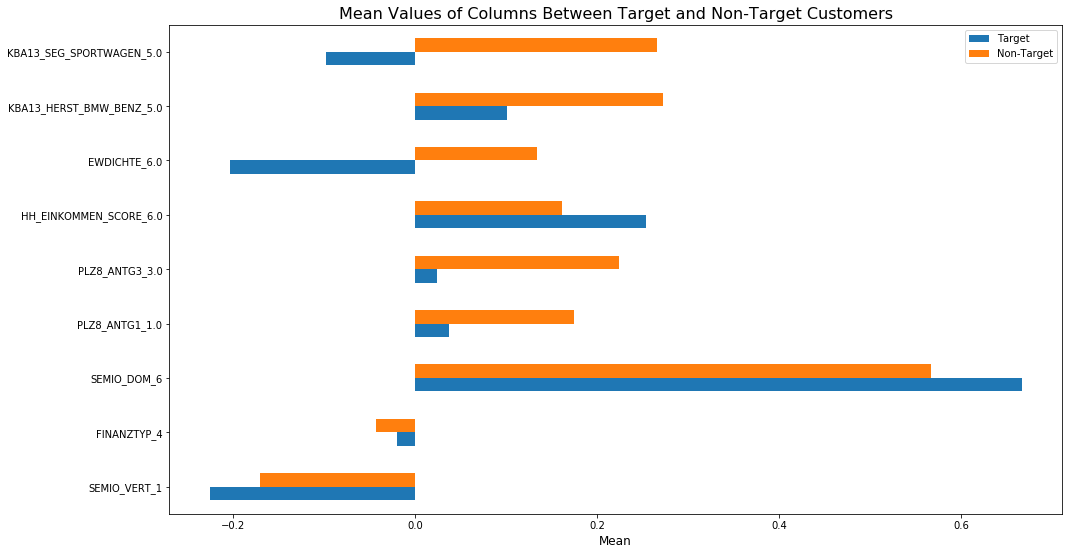

In [79]:
# Plot the means of the columns of interests for the target and non-target groups
fig, ax = plt.subplots(figsize=(16,9))
plt.title("Mean Values of Columns Between Target and Non-Target Customers", fontsize=16)
plt.xlabel("Mean", fontsize=12)
mean_df.plot.barh(ax=ax);


In [80]:
np.abs(over_mean-under_mean).sort_values(ascending=False)

KBA13_SEG_SPORTWAGEN_5.0    0.363876
EWDICHTE_6.0                0.337546
PLZ8_ANTG3_3.0              0.199672
KBA13_HERST_BMW_BENZ_5.0    0.170769
PLZ8_ANTG1_1.0              0.137220
SEMIO_DOM_6                 0.099572
HH_EINKOMMEN_SCORE_6.0      0.092905
SEMIO_VERT_1                0.055339
FINANZTYP_4                 0.022611
Name: mean, dtype: float64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Training Data Preprocessing

In [81]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [82]:
mailout_train = mailout_train.drop('Unnamed: 0',axis = 1)

In [83]:
# Total number of records
n_records = mailout_train.shape[0]

# Number of records where the individual became a customer
n_customer = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]

# Number of records where individual did not become a customer
n_not_customer = mailout_train[mailout_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who became customers
customer_perc = (n_customer / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals who became customers: {}".format(n_customer))
print("Individuals who did not become customers: {}".format(n_not_customer))
print("Percentage of individuals who became customers: {}%".format(customer_perc))


Total number of records: 42962
Individuals who became customers: 532
Individuals who did not become customers: 42430
Percentage of individuals who became customers: 1.2383036171500394%


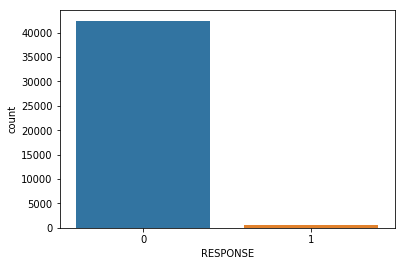

In [84]:
sns.countplot("RESPONSE",data=mailout_train)

In [85]:
# Prepare the data using the function created earlier
mailout_train_clean = clean_data(mailout_train)

In [86]:
# Prepare the data using the function created earlier
mailout_train_clean = clean_data(mailout_train)

In [87]:
mailout_train_clean.columns.get_loc("RESPONSE")

3

In [88]:
mailout_train_clean.shape

(42962, 1088)

In [89]:
# split into train/test
def train_test_split(df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in transaction_df) from the features.
       :param df: Dataframe of all credit card transaction data
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    
    # convert the df into a matrix for ease of splitting
    df_matrix = df.as_matrix()
    df.head()
    # shuffle the data
    np.random.seed(seed)
    np.random.shuffle(df_matrix)
    train_size = int(df_matrix.shape[0] * train_frac)
    print(train_size)
    final_df = pd.DataFrame(df_matrix)
#     final_df.head()
    # split the data
    print(final_df.shape)
    print(final_df.columns)
#     print(final_df[212])
#     print(train_size)
    # features are all but response column
    features= final_df.drop(columns = 3)
    print(features.shape)
    print(features.columns)
    print(212 in features)
    features_matrix = features.as_matrix()
    train_features  = features_matrix[:train_size, :]
    print(train_features.shape)
    # class labels *are response column
    labels = (final_df[3]).as_matrix()
#     print(labels)
    train_labels = labels[:train_size]
    # test data
    test_features = features_matrix[train_size:, :]
    print(test_features.shape)
    test_labels = labels[train_size:]
    
    return (train_features, train_labels), (test_features, test_labels)

In [90]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(mailout_train_clean, train_frac=0.7)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


30073
(42962, 1088)
RangeIndex(start=0, stop=1088, step=1)
(42962, 1087)
Int64Index([   0,    1,    2,    4,    5,    6,    7,    8,    9,   10,
            ...
            1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087],
           dtype='int64', length=1087)
True
(30073, 1087)
(12889, 1087)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [91]:
# manual test

# for a split of 0.7:0.3 there should be ~2.33x as many training as test pts
print('Training data pts: ', len(train_features))
print('Test data pts: ', len(test_features))
print()

# take a look at first item and see that it aligns with first row of data
print('First item: \n', train_features[0])
print('Label: ', train_labels[0])
print()

# test split
assert len(train_features) > 2.333*len(test_features), \
        'Unexpected number of train/test points for a train_frac=0.7'
# test labels
assert np.all(train_labels)== 0 or np.all(train_labels)== 1, \
        'Train labels should be 0s or 1s.'
assert np.all(test_labels)== 0 or np.all(test_labels)== 1, \
        'Test labels should be 0s or 1s.'
print('Tests passed!')


Training data pts:  30073
Test data pts:  12889

First item: 
 [ 1. nan  2. ...  0.  5.  1.]
Label:  0.0

Tests passed!


In [92]:
train_features.shape

(30073, 1087)

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
scaler = StandardScaler()
train_features_impute = imputer.fit_transform(train_features)
train_features_scaled = scaler.fit_transform(train_features_impute)


In [94]:
test_features_impute = imputer.transform(test_features)
test_features_scaled = scaler.transform(test_features_impute)

### AWS SageMaker

In [95]:
import boto3
import sagemaker
from sagemaker import get_execution_role


In [96]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [97]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'capstone_classification'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=5,
                       binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                       target_recall=0.9,
#                        binary_classifier_model_selection_criteria='accuracy',
                       positive_example_weight_mult='balanced')

In [98]:
# convert features/labels to numpy
train_x_np = train_features_scaled.astype('float32')
train_y_np = train_labels.astype('float32')

# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

### Training Model

In [99]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

2019-10-17 19:45:48 Starting - Starting the training job...
2019-10-17 19:45:49 Starting - Launching requested ML instances...
2019-10-17 19:46:43 Starting - Preparing the instances for training......
2019-10-17 19:47:45 Downloading - Downloading input data
2019-10-17 19:47:45 Training - Downloading the training image...
2019-10-17 19:48:15 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[10/17/2019 19:48:18 INFO 140451551082304] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'unif

[2019-10-17 19:48:24.742] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 1380, "num_examples": 31, "num_bytes": 132200908}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.9803293111165364, "sum": 0.9803293111165364, "min": 0.9803293111165364}}, "EndTime": 1571341704.743105, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1571341704.743009}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.9882686665852864, "sum": 0.9882686665852864, "min": 0.9882686665852864}}, "EndTime": 1571341704.743229, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1571341704.743205}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 


2019-10-17 19:48:38 Uploading - Uploading generated training model
2019-10-17 19:48:38 Completed - Training job completed
Training seconds: 70
Billable seconds: 70
CPU times: user 312 ms, sys: 4.81 ms, total: 317 ms
Wall time: 3min 11s


In [100]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------------------------------------------------------------------------------!CPU times: user 399 ms, sys: 50.7 ms, total: 449 ms
Wall time: 10min 15s


In [101]:
# We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint  
test_x_np = test_features_scaled.astype('float32')
prediction_batches = [linear_predictor.predict(batch) for batch in np.array_split(test_x_np, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])

### Model Evaluation

In [102]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


In [103]:
print('Metrics for LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(linear_predictor, 
                   test_features_scaled.astype('float32'), 
                   test_labels, 
                   verbose=True) # verbose means we'll print out the metrics

Metrics for LinearLearner.

prediction (col)   0.0   1.0
actual (row)                
0.0               9167  3561
1.0                113    48

Recall:     0.298
Precision:  0.013
Accuracy:   0.715



### Model on Test Data

In [104]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
mailout_test = mailout_test.drop('Unnamed: 0',axis = 1)

In [106]:
# Prepare the data using the function created earlier
mailout_test_clean = clean_data(mailout_test)

In [107]:
# mailout_train_clean.columns
mailout_test_clean.shape

(42833, 1088)

In [108]:
extra=np.setdiff1d(mailout_test_clean.columns, mailout_train_clean.columns, assume_unique=True)


In [109]:
mailout_test_clean = mailout_test_clean.drop(extra,axis=1)

In [110]:
mailout_test_impute = imputer.transform(mailout_test_clean)
mailout_test_scaled = scaler.transform(mailout_test_impute)

In [111]:
mailout_test_scaled.shape

(42833, 1087)

In [112]:
# test one prediction
test_x_np = mailout_test_scaled.astype('float32')
# result = linear_predictor.predict(test_x_np)

prediction_batches = [linear_predictor.predict(batch) for batch in np.array_split(test_x_np, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [113]:
submission = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=test_preds)

In [114]:
submission.rename(columns={0: "RESPONSE"}, inplace=True)
submission.head()

,RESPONSE
LNR,
1754,0.0
1770,0.0
1465,0.0
1470,0.0
1478,0.0


In [115]:
submission.to_csv('result.csv')

### Deleting Endpoints

In [116]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [117]:
delete_endpoint(linear_predictor)

Deleted linear-learner-2019-10-17-19-45-48-464
